In [ ]:
import os
import torch
from torch.utils.data import DataLoader
from utils.temp_utils import *
from utils.data.chexpert_dataset import CheXpertDataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

CSV_PATH = "Datasets/CheXpertPlus/df_chexpert_plus_240401.csv"
IMG_ROOT = "Datasets/CheXpertPlus/PNG"

TEXT_COL = "section_impression"
PATH_COL = "path_to_image"

IMG_SIZE = 512
MAX_LEN = 64
NUM_BATCH = 4

tf = dino_image_transform(img_size=IMG_SIZE)

ds_train = CheXpertDataset(img_root=IMG_ROOT, csv_path=CSV_PATH, split="train", transform=tf, text_col=TEXT_COL)
ds_valid = CheXpertDataset(img_root=IMG_ROOT, csv_path=CSV_PATH, split="valid", transform=tf, text_col=TEXT_COL)
ds_test = CheXpertDataset(img_root=IMG_ROOT, csv_path=CSV_PATH, split="test", transform=tf, text_col=TEXT_COL)

tok = build_tokenizer_from_labels(gpt2=True)
pad_id = tok.pad_token_id
eos_id = tok.eos_token_id
bos_id = tok.bos_token_id
collate_fn = CaptionCollate(tok, pad_id)

train_loader = DataLoader(ds_train, batch_size=NUM_BATCH, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(ds_valid, batch_size=NUM_BATCH, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(ds_test, batch_size=NUM_BATCH, shuffle=False, collate_fn=collate_fn)

Using device: cuda
[INFO] Kept 95718/223462 rows with existing PNGs
[INFO] Kept 95718/223462 rows with existing PNGs
[INFO] Kept 95718/223462 rows with existing PNGs
Using GPT2 tokenizer.


In [3]:
batch = next(iter(train_loader))

In [4]:
batch[0][0].shape

torch.Size([3, 512, 512])

In [5]:
import torch
import torch.nn as nn

import numpy as np
import torch.nn.functional as F
from transformers import AutoModel

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "Datasets\CheXpertPlus\dino_unet_decoder_finetuned.pth"

class DinoUNet(nn.Module):
    def __init__(self, model_name="facebook/dinov3-convnext-small-pretrain-lvd1689m"):
        super().__init__()
        print("Cargando encoder DINOv3...")
        self.encoder = AutoModel.from_pretrained(model_name).to(DEVICE)
        self.channel_adapter = nn.Conv2d(768, 512, kernel_size=1)
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU(),
            nn.Conv2d(64, 1, 1)
        )

    def forward(self, x):
        enc_feats = self.encoder(x, output_hidden_states=True, return_dict=True)
        feats = next(h for h in reversed(enc_feats.hidden_states) if isinstance(h, torch.Tensor) and h.ndim == 4)
        feats = self.channel_adapter(feats)
        return self.decoder(feats)

class DINOEncoder(nn.Module):
    def __init__(self, model_id="facebook/dinov3-vits16-pretrain-lvd1689m", freeze=True):
        super().__init__()
        from transformers import AutoModel
        self.model = AutoModel.from_pretrained(model_id)
        if freeze:
            for p in self.model.parameters():
                p.requires_grad = False

    @torch.no_grad()
    def forward(self, pixel_values):
        out = self.model(pixel_values=pixel_values)
        tokens = out.last_hidden_state
        cls = tokens[:, 0, :]
        patches = tokens[:, 5:, :]
        return cls, patches

encoder = DINOEncoder().to("cpu")
encoder.eval()

segmentator = DinoUNet().to("cpu")
segmentator.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
segmentator.eval()

from utils.models.modifiedGPT2 import create_decoder
decoder = create_decoder().to(DEVICE)

vis_dim = 384
linear_projection = nn.Linear(vis_dim, decoder.config.n_embd).to(DEVICE)

# -*- coding: utf-8 -*-
import os
import math
import numpy as np
from PIL import Image

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def normalize01_torch(x: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    """
    Normaliza por muestra a [0,1].
    Acepta: (B, H, W) o (B, 1, H, W)
    Devuelve: (B, 1, H, W)
    """
    if x.ndim == 3:        # (B,H,W) -> (B,1,H,W)
        x = x.unsqueeze(1)
    xmin = x.amin(dim=(2,3), keepdim=True)
    xmax = x.amax(dim=(2,3), keepdim=True)
    denom = (xmax - xmin).clamp_min(eps)
    y = (x - xmin) / denom
    # Asegurar 1 canal
    if y.shape[1] != 1:
        y = y[:, :1]
    return y

def _ensure_odd(k: int) -> int:
    k = max(int(k), 1)
    return k if (k % 2 == 1) else (k + 1)

def gaussian_kernel1d_torch(ksize: int, sigma: float | None = None, device=None, dtype=None) -> torch.Tensor:
    """
    1D Gaussian kernel normalizado (suma 1), tamaño impar.
    """
    k = _ensure_odd(ksize)
    if sigma is None or sigma <= 0:
        sigma = (k - 1) / 6.0
    r = k // 2
    x = torch.arange(-r, r + 1, device=device, dtype=torch.float32 if dtype is None else dtype)
    g = torch.exp(-(x**2) / (2.0 * sigma * sigma))
    g = g / g.sum()
    return g  # (k,)

def gaussian_blur2d_with_ksize_torch(x: torch.Tensor, ksize: int, sigma: float | None = None) -> torch.Tensor:
    """
    Desenfoque gaussiano separable 2D con padding reflect.
    x: (B,1,H,W)
    return: (B,1,H,W)
    """
    B, C, H, W = x.shape
    assert C == 1, "Se espera 1 canal"
    device, dtype = x.device, x.dtype

    k1 = gaussian_kernel1d_torch(ksize, sigma, device=device, dtype=dtype)  # (K,)
    pad = k1.numel() // 2

    # Conv horizontal (1xK)
    xh = F.pad(x, (pad, pad, 0, 0), mode="reflect")
    weight_h = k1.view(1, 1, 1, -1)                                        # (outC,inC,1,K)
    xh = F.conv2d(xh, weight_h)

    # Conv vertical (Kx1)
    xv = F.pad(xh, (0, 0, pad, pad), mode="reflect")
    weight_v = k1.view(1, 1, -1, 1)                                        # (outC,inC,K,1)
    out = F.conv2d(xv, weight_v)
    return out

def resize_to_32(x: torch.Tensor) -> torch.Tensor:
    """
    x: (B, H, W) -> (B, 32, 32)
    """
    if x.ndim != 3:
        raise ValueError(f"Expected (B,H,W), got {tuple(x.shape)}")
    x = x.float().unsqueeze(1)  # (B,1,H,W)
    x = F.interpolate(x, size=(32, 32), mode="bilinear", align_corners=False)
    return x.squeeze(1)         # (B,32,32)

def apply_filter(x32: torch.Tensor,
                 layer_idx: int,
                 base_ksize: int = 3,
                 ksize_growth: int = 2,
                 sigma: float | None = None) -> torch.Tensor:
    """
    x32: (B,32,32)
    Normaliza a [0,1], aplica blur gaussiano con ksize creciente por capa y regresa (B,32,32).
    """
    x_norm = normalize01_torch(x32).to(x32.dtype)   # (B,1,32,32)
    ksize = _ensure_odd(base_ksize + layer_idx * ksize_growth)
    y = gaussian_blur2d_with_ksize_torch(x_norm, ksize=ksize, sigma=sigma)  # (B,1,32,32)
    y = normalize01_torch(y).squeeze(1)                                     # (B,32,32)
    return y

def build_layer_stack(x32: torch.Tensor, n_layers: int,
                      base_ksize: int = 3, ksize_growth: int = 2, sigma: float | None = None) -> torch.Tensor:
    """
    Aplica apply_filter() n_layers veces y apila:
    Entrada:  x32 (B,32,32)
    Salida:   (B, n_layers, 32, 32)
    """
    layers = []
    for i in range(n_layers, 0, -1):  # capas n_layers ... 1
        y = apply_filter(x32, layer_idx=i, base_ksize=base_ksize, ksize_growth=ksize_growth, sigma=sigma)  # (B,32,32)
        layers.append(y.unsqueeze(1))  # (B,1,32,32)
    return torch.cat(layers, dim=1)    # (B,n_layers,32,32)

def flatten_and_tile(x_layers: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    """
    x_layers: (B, n_layers, 32, 32)
      -> flat:  (B, n_layers, 1024)
      -> tiled: (B, n_layers, 1024, 1024)  (repitiendo valores a lo largo de la última nueva dimensión)
    """
    B, L, H, W = x_layers.shape
    if (H, W) != (32, 32):
        raise ValueError("Expected spatial size 32x32 before flatten.")
    flat = x_layers.reshape(B, L, H * W)                  # (B,L,1024)
    tiled = flat.unsqueeze(-2).expand(-1, -1, H * W, -1)   # (B,L,1024,1024) tile[0,0,:,j] = flat[0,0,:] for all j
    return flat, tiled

def pipeline(x: torch.Tensor, n_layers: int,
             base_ksize: int = 3, ksize_growth: int = 2, sigma: float | None = None):
    """
    x: (B,H,W)  [cualquier HxW]
    Retorna:
      - stacked: (B, n_layers, 32, 32)
      - flat:    (B, n_layers, 1024)
      - tiled:   (B, n_layers, 1024, 1024)
    """
    x32 = resize_to_32(x)                                                # (B,32,32)
    stacked = build_layer_stack(x32, n_layers, base_ksize, ksize_growth, sigma)  # (B,n_layers,32,32)
    flat, tiled = flatten_and_tile(stacked)
    return stacked, flat, tiled

def plot_stacked_layers(stacked: torch.Tensor, sample_idx: int = 0, cols: int = 6, save_path: str | None = None):
    """
    Muestra en gris cada capa de stacked[sample_idx] en una grilla.
    stacked: (B, n_layers, 32, 32)
    sample_idx: índice del batch a mostrar (default 0)
    cols: columnas de la grilla
    save_path: si no es None, guarda la figura en esa ruta
    """
    if stacked.ndim != 4:
        raise ValueError(f"Expected (B, n_layers, H, W), got {tuple(stacked.shape)}")

    B, L, H, W = stacked.shape
    if sample_idx < 0 or sample_idx >= B:
        raise IndexError(f"sample_idx out of range: {sample_idx} (B={B})")

    imgs = stacked[sample_idx].detach().cpu().numpy().astype(np.float32)  # (L,H,W)

    # Normaliza cada capa a [0,1] individualmente
    mn = imgs.min(axis=(1, 2), keepdims=True)
    mx = imgs.max(axis=(1, 2), keepdims=True)
    denom = np.where((mx - mn) < 1e-8, 1.0, (mx - mn))
    imgs_norm = (imgs - mn) / denom  # (L,H,W) en [0,1]

    rows = math.ceil(L / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.2, rows * 2.2))
    axes = np.atleast_2d(axes).reshape(rows, cols)

    for i in range(rows * cols):
        ax = axes[i // cols, i % cols]
        ax.axis('off')
        if i < L:
            ax.imshow(imgs_norm[i], cmap='gray', vmin=0.0, vmax=1.0)
            ax.set_title(f"Layer {i}", fontsize=8)
        else:
            ax.imshow(np.zeros((H, W), dtype=np.float32), cmap='gray', vmin=0.0, vmax=1.0)

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    return fig

def denormalize(image_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(image_tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(image_tensor.device)
    image_tensor = image_tensor * std + mean
    image_tensor = torch.clamp(image_tensor, 0, 1)
    image_tensor = (image_tensor * 255).byte()
    return image_tensor

from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# with torch.no_grad():
#     pixel_values, tgt_ids, paths, raw_labels = next(iter(train_loader))
#     pixel_values = pixel_values.to(DEVICE)

#     pred = segmentator(pixel_values)
#     pred = F.interpolate(pred, size=(IMG_SIZE, IMG_SIZE), mode="bilinear", align_corners=False)
#     pred_sig = torch.sigmoid(pred).cpu().numpy()
#     masks = (pred_sig[:, 0] > 0.5).astype(np.uint8) * 255
#     B = masks.shape[0]
#     n_layers = decoder.config.num_hidden_layers
#     BASE_KSIZE = 3
#     KSIZE_GROW = 4
#     SIGMA = None  # heurística

#     stacked, flat, tiled = pipeline(torch.tensor(masks), n_layers, BASE_KSIZE, KSIZE_GROW, SIGMA)
#     print("stacked:", stacked.shape)  # (B,12,32,32)
#     print("flat:   ", flat.shape)     # (B,12,1024)
#     print("tiled:  ", tiled.shape)    # (B,12,1024,1024)

#     _, patches = encoder(pixel_values)
    
#     patches = linear_projection(patches)
    
#     # logits = decoder(inputs_embeds=patches, segmentation_mask=tiled.to(DEVICE))

#     gen_ids = decoder.generate(inputs_embeds=patches,
#                          max_new_tokens=100,
#                          do_sample=False,           # False -> greedy / beams 
#                          repetition_penalty=1.2,
#                          eos_token_id=tokenizer.eos_token_id,
#                          pad_token_id=tokenizer.pad_token_id,
#                          segmentation_mask=tiled.to(DEVICE),
#                          prefix_allowed_length=0,
#                          plot_attention_mask=False,
#                          plot_attention_mask_layer=[0, 6],
#                          plot_attention_map=True,
#                          plot_attention_map_layer=[0, 6],
#                          plot_attention_map_generation=0)
    
#     text = tokenizer.batch_decode(gen_ids, skip_special_tokens=True)

#     for b in range(B):
#         print(f"Example {b} out of {B} in Batch")
#         plt.figure(figsize=(4, 2))
#         plt.subplot(1, 2, 1)
#         plt.title("Input Image")
#         plt.imshow(denormalize(pixel_values[b]).permute(1, 2, 0).cpu().numpy().astype(np.uint8))
#         plt.axis("off")

#         plt.subplot(1, 2, 2)
#         plt.title("Predicted Mask")
#         plt.imshow(masks[b], cmap="gray")
#         plt.axis("off")
#         plt.show()

#         print("Segmentation mask per layer")
#         plot_stacked_layers(stacked, sample_idx=b, cols=6)
#         plt.show()

#         print("Generated text:",text[b])

#         print("Original Impression Text:", raw_labels[b])

Cargando encoder DINOv3...


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
import numpy as np
import matplotlib.pyplot as plt

# -------------------
# Config / Utilities
# -------------------
vis_dim = 384
lr = 5e-5
weight_decay = 0.01
epochs = 1          # increase for real training
grad_clip = 1.0
BASE_KSIZE = 3
KSIZE_GROW = 4
SIGMA = None        # your heuristic

# Ensure tokenizer has PAD (we won't create attention masks, but we'll mask pads in labels)
if getattr(tokenizer, "pad_token", None) is None:
    tokenizer.pad_token = tokenizer.eos_token
pad_id = tokenizer.pad_token_id

# -------------------
# Trainables / Freeze
# -------------------
linear_projection = nn.Linear(vis_dim, decoder.config.n_embd).to(DEVICE)

# Freeze encoder & segmentator
encoder.eval().to("cpu")
for p in encoder.parameters():
    p.requires_grad = False

segmentator.eval().to("cpu")
for p in segmentator.parameters():
    p.requires_grad = False

# Train only linear_projection + decoder
decoder.train()
for p in decoder.parameters():
    p.requires_grad = True
for p in linear_projection.parameters():
    p.requires_grad = True

optim = AdamW(
    list(linear_projection.parameters()) + list(decoder.parameters()),
    lr=lr, weight_decay=weight_decay
)

# ============================================
# GPU-First Training + Optimized Pipeline (Full, fixed)
# ============================================
import time
import math
from contextlib import nullcontext
from typing import Tuple

import torch
import torch.nn.functional as F

# -------------------
# Device & perf setup
# -------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

use_amp = (DEVICE.type == "cuda")
amp_dtype = torch.float16 if use_amp else torch.bfloat16
autocast_ctx = torch.autocast(device_type=DEVICE.type, dtype=amp_dtype, enabled=use_amp) if use_amp else nullcontext()
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cuda.matmul.allow_tf32 = True

# ---------------------------------------
# Ensure model modes/devices (you provide these)
# ---------------------------------------
segmentator.to(DEVICE).eval()          # frozen
encoder.to(DEVICE).eval()              # frozen
linear_projection.to(DEVICE).train()   # trainable
decoder.to(DEVICE).train()             # trainable

# --------------------------
# Utility: CUDA-aware timing
# --------------------------
def _cuda_sync():
    if DEVICE.type == "cuda":
        torch.cuda.synchronize()

def _now():
    _cuda_sync()
    return time.perf_counter()

def _fmt_eta(seconds: float) -> str:
    if seconds is None or math.isinf(seconds) or math.isnan(seconds):
        return "ETA: --:--:--"
    seconds = max(0, int(seconds))
    h = seconds // 3600
    m = (seconds % 3600) // 60
    s = seconds % 60
    return f"ETA: {h:02d}:{m:02d}:{s:02d}"

# ==========================
# Optimized pipeline helpers
# ==========================

def normalize01_torch(x: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    """
    Normalize per-sample to [0,1].
    Accepts: (B,H,W) or (B,1,H,W)
    Returns: (B,1,H,W) on same device/dtype (float)
    """
    if x.ndim == 3:
        x = x.unsqueeze(1)  # (B,1,H,W)
    if not x.is_floating_point():
        x = x.float()
    # Use separate amin/amax for older torch versions
    xmin = x.amin(dim=(2, 3), keepdim=True)
    xmax = x.amax(dim=(2, 3), keepdim=True)
    denom = (xmax - xmin).clamp_min(eps)
    y = (x - xmin) / denom
    if y.shape[1] != 1:
        y = y[:, :1]
    return y

def _ensure_odd(k: int) -> int:
    k = max(int(k), 1)
    return k if (k % 2 == 1) else (k + 1)

# lightweight kernel cache: {(ksize, device_str, dtype, sigma): 1D kernel}
_gauss_cache: dict = {}

def gaussian_kernel1d_torch(ksize: int, sigma: float | None = None, device=None, dtype=None) -> torch.Tensor:
    """
    Normalized 1D Gaussian kernel (sum=1), odd size, cached per (ksize, device, dtype, sigma).
    """
    k = _ensure_odd(ksize)
    if sigma is None or sigma <= 0:
        sigma = (k - 1) / 6.0
    kdtype = dtype if dtype is not None else torch.float32
    dev_key = str(device) if isinstance(device, torch.device) else str(device)
    key = (k, dev_key, kdtype, float(sigma))
    ker = _gauss_cache.get(key)
    if ker is not None:
        return ker
    r = k // 2
    x = torch.arange(-r, r + 1, device=device, dtype=kdtype)
    g = torch.exp(-(x * x) / (2.0 * sigma * sigma))
    g = g / g.sum()
    _gauss_cache[key] = g
    return g  # (k,)

def gaussian_blur2d_with_ksize_torch(x: torch.Tensor, ksize: int, sigma: float | None = None) -> torch.Tensor:
    """
    Separable 2D Gaussian blur with 'reflect' padding.
    x: (B,1,H,W) float
    return: (B,1,H,W) float
    """
    B, C, H, W = x.shape
    assert C == 1, "Expected 1 channel"

    k1 = gaussian_kernel1d_torch(ksize, sigma, device=x.device, dtype=x.dtype)  # (K,)
    pad = int(k1.numel() // 2)

    # horizontal 1xK
    xh = F.pad(x, (pad, pad, 0, 0), mode="reflect")
    weight_h = k1.view(1, 1, 1, -1)  # (outC,inC,1,K)
    xh = F.conv2d(xh, weight_h)

    # vertical Kx1
    xv = F.pad(xh, (0, 0, pad, pad), mode="reflect")
    weight_v = k1.view(1, 1, -1, 1)  # (outC,inC,K,1)
    out = F.conv2d(xv, weight_v)
    return out

def resize_to_32(x: torch.Tensor) -> torch.Tensor:
    """
    x: (B, H, W) or (B,1,H,W) -> (B, 32, 32) float (no CPU hop)
    """
    if x.ndim == 3:
        x = x.unsqueeze(1)  # (B,1,H,W)
    elif x.ndim != 4 or x.shape[1] != 1:
        raise ValueError(f"Expected (B,H,W) or (B,1,H,W), got {tuple(x.shape)}")
    x = x.float()
    x = F.interpolate(x, size=(32, 32), mode="bilinear", align_corners=False)
    return x.squeeze(1)  # (B,32,32)

def apply_filter_once(x32_norm_1ch: torch.Tensor,
                      layer_idx: int,
                      base_ksize: int = 3,
                      ksize_growth: int = 2,
                      sigma: float | None = None) -> torch.Tensor:
    """
    x32_norm_1ch: (B,1,32,32) already normalized [0,1].
    Returns (B,32,32), normalized again to [0,1] after blur (to match original behavior).
    """
    ksize = _ensure_odd(base_ksize + layer_idx * ksize_growth)
    y = gaussian_blur2d_with_ksize_torch(x32_norm_1ch, ksize=ksize, sigma=sigma)  # (B,1,32,32)
    y = normalize01_torch(y).squeeze(1)                                           # (B,32,32)
    return y

def build_layer_stack_optimized(x32: torch.Tensor,
                                n_layers: int,
                                base_ksize: int = 3,
                                ksize_growth: int = 2,
                                sigma: float | None = None) -> torch.Tensor:
    """
    Applies Gaussian blur with growing ksize across layers, but normalizes the input ONCE.
    Input:  x32 (B,32,32)
    Output: (B, n_layers, 32, 32), ordered as layers n_layers ... 1 (to match your original)
    """
    x_norm_1ch = normalize01_torch(x32).to(x32.dtype)  # (B,1,32,32)
    layers = []
    for i in range(n_layers, 0, -1):
        y = apply_filter_once(x_norm_1ch, layer_idx=i, base_ksize=base_ksize, ksize_growth=ksize_growth, sigma=sigma)
        layers.append(y.unsqueeze(1))  # (B,1,32,32)
    return torch.cat(layers, dim=1)    # (B,n_layers,32,32)

def flatten_and_tile(x_layers: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    x_layers: (B, n_layers, 32, 32)
      -> flat:  (B, n_layers, 1024)
      -> tiled: (B, n_layers, 1024, 1024)   (created via expand: view, not copy)
    NOTE: The expanded view is memory-cheap, but downstream ops that force materialization can explode memory.
    """
    B, L, H, W = x_layers.shape
    if (H, W) != (32, 32):
        raise ValueError("Expected spatial size 32x32 before flatten.")
    flat = x_layers.reshape(B, L, H * W)                     # (B,L,1024)
    tiled = flat.unsqueeze(-2).expand(-1, -1, H * W, -1)     # (B,L,1024,1024) view
    return flat, tiled

def pipeline(x: torch.Tensor,
             n_layers: int,
             base_ksize: int = 3,
             ksize_growth: int = 2,
             sigma: float | None = None):
    """
    x: (B,H,W) or (B,1,H,W) on any device
    Returns:
      - stacked: (B, n_layers, 32, 32)
      - flat:    (B, n_layers, 1024)
      - tiled:   (B, n_layers, 1024, 1024)  (expand view)
    """
    x32 = resize_to_32(x)  # (B,32,32)
    stacked = build_layer_stack_optimized(x32, n_layers, base_ksize, ksize_growth, sigma)  # (B,n_layers,32,32)
    flat, tiled = flatten_and_tile(stacked)
    return stacked, flat, tiled

# ======================================================
# Batch builder (GPU-first) that uses the optimized pipe
# ======================================================
def build_batch_gpu(pixel_values: torch.Tensor,
                    tgt_ids: torch.Tensor,
                    *,
                    pipeline_on: str = "gpu"):
    """
    Returns:
      inputs_embeds: [B, Np+T, n_embd] (DEVICE)
      labels:        [B, Np+T] with prefix=-100 & PADs -> -100 (DEVICE)
      segmask_tiled: tiled segmentation guidance (DEVICE)
    """
    B = pixel_values.size(0)

    # ===== Segmentation (frozen) =====
    with torch.inference_mode():
        pred = segmentator(pixel_values)  # [B,1,H,W] on DEVICE
        pred = F.interpolate(pred, size=(IMG_SIZE, IMG_SIZE), mode="bilinear", align_corners=False)
        pred = pred.sigmoid_()                       # (B,1,H,W)
        segmask_bool = pred[:, 0].gt_(0.5)           # (B,H,W) bool
        segmask_255  = segmask_bool.to(torch.uint8).mul_(255)  # (B,H,W) uint8

    # ===== Pipeline (tiled mask guidance) =====
    n_layers = decoder.config.num_hidden_layers
    if pipeline_on.lower() == "cpu":
        segmask_cpu = segmask_255.detach().to("cpu")
        _, _, tiled = pipeline(segmask_cpu, n_layers, BASE_KSIZE, KSIZE_GROW, SIGMA)
        segmask_tiled = tiled.to(DEVICE, non_blocking=True)
    else:
        _, _, tiled = pipeline(segmask_255, n_layers, BASE_KSIZE, KSIZE_GROW, SIGMA)
        segmask_tiled = tiled if tiled.device == DEVICE else tiled.to(DEVICE, non_blocking=True)

    # ===== Visual prefix (encoder frozen; projection trainable) =====
    with torch.inference_mode():
        _, patches = encoder(pixel_values)           # [B,Np,vis_dim]
    if patches.device != DEVICE:
        patches = patches.to(DEVICE, non_blocking=True)
    prefix = linear_projection(patches)              # [B,Np,n_embd]

    # ===== Text embeddings from GPT-2 table =====
    if tgt_ids.device != DEVICE:
        tgt_ids = tgt_ids.to(DEVICE, non_blocking=True)
    text_embeds = decoder.transformer.wte(tgt_ids)   # [B,T,n_embd]

    # ===== Concatenate prefix + text =====
    inputs_embeds = torch.cat([prefix, text_embeds], dim=1)  # [B,Np+T,n_embd]

    # ===== Labels =====
    labels_prefix = torch.full((B, prefix.size(1)), -100, device=DEVICE, dtype=torch.long)
    text_labels = tgt_ids.clone()
    text_labels[text_labels == pad_id] = -100
    labels = torch.cat([labels_prefix, text_labels], dim=1)  # [B,Np+T] on DEVICE

    return inputs_embeds, labels#, segmask_tiled

# =================
# Training loop w/ ETA
# =================
# clip only the trainables
trainable_params = [p for p in list(decoder.parameters()) + list(linear_projection.parameters())
                    if p.requires_grad]

# Determine steps/epoch for ETA
try:
    loader_len = len(train_loader)
except TypeError:
    loader_len = None

step_cap = 2000  # keep your demo cap
steps_per_epoch = min(step_cap, loader_len) if loader_len is not None else step_cap
total_steps_all = steps_per_epoch * epochs

global_step = 0
ema_step_time = None
ema_alpha = 0.1  # smoothing factor

def _eta_from(ema_step_time: float, ep: int, step_in_epoch: int) -> str:
    steps_left_this_epoch = steps_per_epoch - step_in_epoch
    epochs_left = epochs - (ep + 1)
    steps_left_total = steps_left_this_epoch + epochs_left * steps_per_epoch
    return _fmt_eta(ema_step_time * steps_left_total)

train_start = _now()

for ep in range(epochs):
    running = 0.0

    if DEVICE.type == "cuda":
        torch.cuda.reset_peak_memory_stats()

    epoch_start = _now()

    for step, (pixel_values, target_ids, paths, raw_labels) in enumerate(train_loader):
        if step >= steps_per_epoch:
            break

        t0 = _now()

        pixel_values = pixel_values.to(DEVICE, non_blocking=True)
        target_ids   = target_ids.to(DEVICE, non_blocking=True)

        # inputs_embeds, labels, segmask_tiled = build_batch_gpu(pixel_values, target_ids, pipeline_on="gpu")
        inputs_embeds, labels = build_batch_gpu(pixel_values, target_ids, pipeline_on="gpu")

        optim.zero_grad(set_to_none=True)
        with autocast_ctx:
            out = decoder(
                inputs_embeds=inputs_embeds,
                labels=labels,                 # GPT-2 shifts internally
                segmentation_mask=None,#segmask_tiled,
            )
            loss = out.loss

        scaler.scale(loss).backward()
        scaler.unscale_(optim)
        torch.nn.utils.clip_grad_norm_(trainable_params, grad_clip)
        scaler.step(optim)
        scaler.update()

        running += float(loss.detach())

        # ---- step timing & ETA ----
        t1 = _now()
        step_time = t1 - t0
        if ema_step_time is None:
            ema_step_time = step_time
        else:
            ema_step_time = ema_alpha * step_time + (1 - ema_alpha) * ema_step_time

        if (step + 1) % 5 == 0:
            avg_loss = running / (step + 1)
            print(f"[epoch {ep+1}/{epochs}] step {step+1}/{steps_per_epoch} "
                  f"loss {avg_loss:.4f} | step {step_time:.3f}s | avg {ema_step_time:.3f}s | {_eta_from(ema_step_time, ep, step+1)}")

        if (step + 1) in [200, 1000, steps_per_epoch]:
            print("Saving decoder and linear projection model checkpoint...")
            torch.save(linear_projection.state_dict(), f"Datasets/CheXpertPlus/linear_projection_nomask_{step+1}.pth")
            torch.save(decoder.state_dict(),            f"Datasets/CheXpertPlus/decoder_nomask_{step+1}.pth")

        #del pixel_values, target_ids, inputs_embeds, labels, segmask_tiled, out, loss
        del pixel_values, target_ids, inputs_embeds, labels, out, loss

    epoch_time = _now() - epoch_start
    if DEVICE.type == "cuda":
        peak_mem = torch.cuda.max_memory_allocated() / (1024**2)
        print(f"Epoch {ep+1}/{epochs} avg loss: {running / steps_per_epoch:.4f} | "
              f"epoch time: {epoch_time:.1f}s | peak GPU mem: {peak_mem:.1f} MB | {_eta_from(ema_step_time, ep, steps_per_epoch)}")
    else:
        print(f"Epoch {ep+1}/{epochs} avg loss: {running / steps_per_epoch:.4f} | "
              f"epoch time: {epoch_time:.1f}s | {_eta_from(ema_step_time, ep, steps_per_epoch)}")

train_total = _now() - train_start
print(f"Training completed in {train_total/3600:.2f}h.")

Using device: cuda


C:\Users\emman\AppData\Local\Temp\ipykernel_18684\1430358883.py:71: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
c:\Users\emman\Desktop\PROYECTOS_VS_CODE\PRUEBAS_DE_PYTHON\Chest-X-ray-Diagnosis-Automated-Reporting-using-CNNs-and-LLMs---UDEM-PEF-Thesis-Fall-2025\venv-chest\lib\site-packages\torch\backends\__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorc

[epoch 1/1] step 5/2000 loss 7.6507 | step 0.887s | avg 1.713s | ETA: 00:56:56
[epoch 1/1] step 10/2000 loss 7.0660 | step 1.084s | avg 1.518s | ETA: 00:50:21
[epoch 1/1] step 15/2000 loss 6.5228 | step 1.127s | avg 1.393s | ETA: 00:46:04
[epoch 1/1] step 20/2000 loss 6.1192 | step 1.514s | avg 1.341s | ETA: 00:44:14
[epoch 1/1] step 25/2000 loss 5.7879 | step 1.167s | avg 1.315s | ETA: 00:43:16
[epoch 1/1] step 30/2000 loss 5.5535 | step 1.164s | avg 1.296s | ETA: 00:42:34
[epoch 1/1] step 35/2000 loss 5.3411 | step 1.160s | avg 1.275s | ETA: 00:41:45
[epoch 1/1] step 40/2000 loss 5.1327 | step 1.346s | avg 1.269s | ETA: 00:41:27
[epoch 1/1] step 45/2000 loss 4.9641 | step 1.228s | avg 1.237s | ETA: 00:40:18
[epoch 1/1] step 50/2000 loss 4.8328 | step 1.724s | avg 1.463s | ETA: 00:47:33
[epoch 1/1] step 55/2000 loss 4.7128 | step 1.812s | avg 1.545s | ETA: 00:50:05
[epoch 1/1] step 60/2000 loss 4.6015 | step 1.164s | avg 1.458s | ETA: 00:47:09
[epoch 1/1] step 65/2000 loss 4.4928 | st

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



Example 0 / 3
Generated text: . no significant interval change in cardiopulmonary status with persistent bilateral pleural effusions and bibasilar opacities which may represent atelectasis or consolidation versus aspiration pneumonia. stable appearance of the chest radiograph dated 8122008 from the patient's physician to the patients known history of cystic fibrosis as well as prior pulmonary edema on the ct scan. redemonstration of a leftsided picc line unchanged compared to the previous examination but slightly decreased size since the previously
Original Impression Text: slightly improved minimal aeration of the left lung. unchanged right pulmonary edema. physician to physician radiology consult line 4474643790 i have personally reviewed the images for this examination and agreed with the report transcribed above.

Example 1 / 3
Generated text:  right internal jugular central venous catheter and left upper extremity picc line unchanged. persistent low lung volumes with bibasilar op

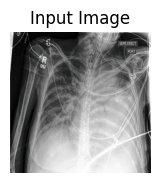

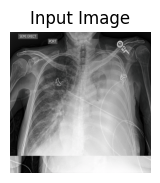

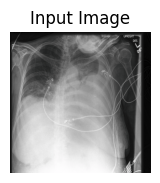

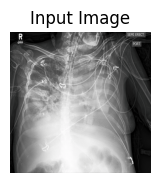

In [7]:
# -----------------------
# One-batch TEST (GEN)
# -----------------------
decoder.eval()
linear_projection.eval()

generated_text, target_text = [], []
iteration = 0

@torch.inference_mode()
def build_segmask_tiled(pixel_values: torch.Tensor) -> torch.Tensor:
    """
    pixel_values: [B, C, H, W] on DEVICE
    returns segmask_tiled: (B, n_layers, 1024, 1024) on DEVICE (expand/view from pipeline)
    """
    pred = segmentator(pixel_values)  # [B,1,H,W] logits on DEVICE
    pred = F.interpolate(pred, size=(IMG_SIZE, IMG_SIZE), mode="bilinear", align_corners=False)
    pred = pred.sigmoid_()
    segmask_bool = pred[:, 0].gt_(0.5)                 # (B,H,W) bool
    segmask_255 = segmask_bool.to(torch.uint8).mul_(255)  # (B,H,W) uint8 on DEVICE

    n_layers = decoder.config.num_hidden_layers
    # GPU pipeline; returns stacked, flat, tiled (views on DEVICE)
    stacked, _, tiled = pipeline(segmask_255, n_layers, BASE_KSIZE, KSIZE_GROW, SIGMA)
    return segmask_255, stacked, tiled if tiled.device == DEVICE else tiled.to(DEVICE, non_blocking=True)


with torch.inference_mode():
    for pixel_values, ids_loader, paths, raw_labels in test_loader:
        iteration += 1
        # Fast H2D
        pixel_values = pixel_values.to(DEVICE, non_blocking=True)

        # Build GPU segmentation guidance (tiled)
        # masks, stacked, segmask_tiled = build_segmask_tiled(pixel_values)  # (B, L, 1024, 1024) on DEVICE

        # Visual prefix
        _, patches = encoder(pixel_values)               # [B,Np,vis_dim] on DEVICE
        prefix = linear_projection(patches)              # [B,Np,n_embd] on DEVICE

        # Generate (disable all plotting/diagnostics for speed)
        gen_ids = decoder.generate(
            inputs_embeds=prefix,
            max_new_tokens=100,
            do_sample=False,
            repetition_penalty=1.2,
            eos_token_id=eos_id,
            pad_token_id=pad_id,
            use_cache=True,
            segmentation_mask=None,#segmask_tiled,
            prefix_allowed_length=0,
            plot_attention_mask=False,
            plot_attention_mask_layer=[],
            plot_attention_map=False,
            plot_attention_map_layer=[],
            plot_attention_map_generation=0,
        )
        # Move only the ids needed for decoding to CPU
        texts = tokenizer.batch_decode(gen_ids.detach().cpu(), skip_special_tokens=True)

        # Accumulate for final metric pass (metrics often run on CPU/strings anyway)
        generated_text.extend(texts)
        target_text.extend(raw_labels)

        if iteration >= 1:  # your test cap
            break

    # ---- Simple visualization / logging per sample ----
    for b in range(NUM_BATCH):
        print(f"\nExample {b} / {NUM_BATCH-1}")
        plt.figure(figsize=(4, 2))
        plt.subplot(1, 2, 1)
        plt.title("Input Image")
        plt.imshow(denormalize(pixel_values[b]).permute(1, 2, 0).cpu().numpy().astype(np.uint8))
        plt.axis("off")

        # plt.subplot(1, 2, 2)
        # plt.title("Predicted Mask")
        # plt.imshow(masks[b].detach().cpu().numpy(), cmap="gray")
        # plt.axis("off")
        # plt.show()

        # print("Segmentation mask per layer")
        # plot_stacked_layers(stacked, sample_idx=b, cols=6)
        # plt.show()

        print("Generated text:", texts[b])
        print("Original Impression Text:", raw_labels[b])



In [8]:
print("Segmentator parameters to train:", sum(p.requires_grad for p in segmentator.parameters()))
print("Encoder parameters to train:", sum(p.requires_grad for p in encoder.parameters()))
print("Linear projection parameters to train:", sum(p.requires_grad for p in linear_projection.parameters()))
print("Total linear projection parameters:", sum(p.numel() for p in linear_projection.parameters() if p.requires_grad))
print("Decoder parameters to train:", sum(p.requires_grad for p in decoder.parameters()))
print("Total decoder parameters:", sum(p.numel() for p in decoder.parameters() if p.requires_grad))
print("Total trainable parameters:", 
      sum(p.numel() for p in segmentator.parameters() if p.requires_grad) +
      sum(p.numel() for p in encoder.parameters() if p.requires_grad) +
      sum(p.numel() for p in linear_projection.parameters() if p.requires_grad) +
      sum(p.numel() for p in decoder.parameters() if p.requires_grad)
     )

Segmentator parameters to train: 0
Encoder parameters to train: 0
Linear projection parameters to train: 2
Total linear projection parameters: 295680
Decoder parameters to train: 148
Total decoder parameters: 125226240
Total trainable parameters: 125521920


In [12]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from utils.text_metrics import evaluate_all_metrics, save_metrics_to_json

# -----------------------
# Device & perf settings
# -----------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cuda.matmul.allow_tf32 = True

# Ensure models are on device and eval
segmentator.to(DEVICE).eval()
encoder.to(DEVICE).eval()
linear_projection.to(DEVICE).eval()   # eval for inference
decoder.to(DEVICE).eval()

# -------------
# Eval config
# -------------
epochs = [10, 50, 100]
model_names = ['200', '1000', '2000']
training_time = [360, 1800, 3600]

# single test loader (no shuffle), pinned for faster H2D
test_loader = DataLoader(
    ds_test,
    batch_size=NUM_BATCH,
    shuffle=False,
    collate_fn=collate_fn,
)

# helpful ids
eos_id = tokenizer.eos_token_id
pad_id = tokenizer.pad_token_id

# -----------------
# Helper for masks
# -----------------
@torch.inference_mode()
def build_segmask_tiled(pixel_values: torch.Tensor) -> torch.Tensor:
    """
    pixel_values: [B, C, H, W] on DEVICE
    returns segmask_tiled: (B, n_layers, 1024, 1024) on DEVICE (expand/view from pipeline)
    """
    pred = segmentator(pixel_values)  # [B,1,H,W] logits on DEVICE
    pred = F.interpolate(pred, size=(IMG_SIZE, IMG_SIZE), mode="bilinear", align_corners=False)
    pred = pred.sigmoid_()
    segmask_bool = pred[:, 0].gt_(0.5)                 # (B,H,W) bool
    segmask_255 = segmask_bool.to(torch.uint8).mul_(255)  # (B,H,W) uint8 on DEVICE

    n_layers = decoder.config.num_hidden_layers
    # GPU pipeline; returns stacked, flat, tiled (views on DEVICE)
    _, _, tiled = pipeline(segmask_255, n_layers, BASE_KSIZE, KSIZE_GROW, SIGMA)
    return tiled if tiled.device == DEVICE else tiled.to(DEVICE, non_blocking=True)

# -----------------
# Main evaluation
# -----------------
for i, model_name in enumerate(model_names):
    # Load weights directly to DEVICE
    decoder_path = f"Datasets/CheXpertPlus/decoder_nomask_{model_name}.pth"
    linear_projection_path = f"Datasets/CheXpertPlus/linear_projection_nomask_{model_name}.pth"
    decoder.load_state_dict(torch.load(decoder_path, map_location=DEVICE), strict=True)
    linear_projection.load_state_dict(torch.load(linear_projection_path, map_location=DEVICE), strict=True)

    decoder.eval()
    linear_projection.eval()

    generated_text, target_text = [], []
    iteration = 0

    with torch.inference_mode():
        for pixel_values, ids_loader, paths, raw_labels in test_loader:
            iteration += 1
            # Fast H2D
            pixel_values = pixel_values.to(DEVICE, non_blocking=True)

            # Build GPU segmentation guidance (tiled)
            #segmask_tiled = build_segmask_tiled(pixel_values)  # (B, L, 1024, 1024) on DEVICE

            # Visual prefix
            _, patches = encoder(pixel_values)               # [B,Np,vis_dim] on DEVICE
            prefix = linear_projection(patches)              # [B,Np,n_embd] on DEVICE

            # Generate (disable all plotting/diagnostics for speed)
            gen_ids = decoder.generate(
                inputs_embeds=prefix,
                max_new_tokens=100,
                do_sample=False,
                repetition_penalty=1.2,
                eos_token_id=eos_id,
                pad_token_id=pad_id,
                use_cache=True,
                segmentation_mask=None,#segmask_tiled,
                prefix_allowed_length=0,
                plot_attention_mask=False,
                plot_attention_mask_layer=[],
                plot_attention_map=False,
                plot_attention_map_layer=[],
                plot_attention_map_generation=0,
            )
            # Move only the ids needed for decoding to CPU
            texts = tokenizer.batch_decode(gen_ids.detach().cpu(), skip_special_tokens=True)

            # Accumulate for final metric pass (metrics often run on CPU/strings anyway)
            generated_text.extend(texts)
            target_text.extend(raw_labels)

            if iteration >= 200:  # your test cap
                break

    # Evaluate once per model
    eval_results = evaluate_all_metrics(
        generated=generated_text,
        original=target_text,
        evaluation_mode="CheXagent"
    )

    print(f"\nOverall results for model trained {epochs[i]} epochs:")
    for metric, scores in eval_results.items():
        print(f"{metric}: {scores}")

    # add training walltime you tracked
    eval_results["training_time_seconds"] = training_time[i]

    # Save metrics
    save_metrics_to_json(
        eval_results,
        f"lstm-vs-gpt/results/gpt2_modified_model_nomask_results_{epochs[i]}_Chexpert.json"
    )


Using device: cuda:0

Overall results for model trained 10 epochs:
chexbert_f1_weighted: 0.40956551619784587
chexbert_f1_micro: 0.409129095491459
chexbert_f1_macro: 0.24513077025545527
chexbert_f1_micro_5: 0.4170755642787046
chexbert_f1_macro_5: 0.384300047580814
radgraph_f1_RG_E: 0.19063892700082857
radgraph_f1_RG_ER: 0.15495583650879063
Using device: cuda:0

Overall results for model trained 50 epochs:
chexbert_f1_weighted: 0.4609156319817668
chexbert_f1_micro: 0.4426078971533517
chexbert_f1_macro: 0.2634906008181698
chexbert_f1_micro_5: 0.49770031469377873
chexbert_f1_macro_5: 0.4108381959561439
radgraph_f1_RG_E: 0.17363738688887664
radgraph_f1_RG_ER: 0.14595840801259313
Using device: cuda:0

Overall results for model trained 100 epochs:
chexbert_f1_weighted: 0.49336475978697575
chexbert_f1_micro: 0.4828892195319897
chexbert_f1_macro: 0.2744629869433041
chexbert_f1_micro_5: 0.4672692413037524
chexbert_f1_macro_5: 0.39459950883315964
radgraph_f1_RG_E: 0.20672292513136575
radgraph_f1_

In [10]:

text = "Original Impression Text: left hemithorax complete opacification likely due to further enlarged large pleural effusion with complete left lung collapse. unchanged right right pleural effusion with right basilar opacity suggestive of compressive atelectasis. physician to physician radiology consult line 379 6020819 i have personally reviewed the images for this examination and agreed with the report transcribed above."
import re
# Extract everything before "physician to physician"
cutoff = "physician to physician"
before = text.split(cutoff)[0].strip()

print(before)

Original Impression Text: left hemithorax complete opacification likely due to further enlarged large pleural effusion with complete left lung collapse. unchanged right right pleural effusion with right basilar opacity suggestive of compressive atelectasis.
